- In this notebook, I show the performance of PNet and generated the input data of RNet  
- As I mentioned in the first notebook (step 1), I will not show the repetitive parts. 

## The PNet Box
- Given an image, this part initially resize it to different scales to bulid an image pyramid, which is the input of the PNet

- Then, it puts the images of the image pramid into PNet to get prediction boxes, converts the boxes into squares and calibrates them according to the offset values.

- After that, it chooses the boxes that might have face (larger than **MIN_FACE_SIZE**) based on the **THRESHOLDS** and deletes the repetitive boxes based on the **NMS_THRESHOLDS**  
- Finally, it returns the bounding box information to show the images.

In [6]:
THRESHOLDS = [0.85]
NMS_THRESHOLDS = [0.5]
MIN_FACE_SIZE = 15.0

def pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS):
    pnet.eval()
    width, height = img.size
    min_length = min(height, width)
    min_detection_size = 12
    factor = 0.707  # sqrt(0.5)
    scales = []
    m = min_detection_size / min_face_size
    min_length *= m
    factor_count = 0
    while min_length > min_detection_size:
        scales.append(m * factor ** factor_count)
        min_length *= factor
        factor_count += 1

    bounding_boxes = []
    for s in scales:  
        boxes = run_first_stage(img, pnet, scale=s, threshold=thresholds[0])
        bounding_boxes.append(boxes)
    bounding_boxes = [i for i in bounding_boxes if i is not None]
    try:
        _ = bounding_boxes[0]
    except Exception:
        img.show()
    if len(bounding_boxes) == 0:
        return None
    bounding_boxes = np.vstack(bounding_boxes)

    keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0])
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
    
    return bounding_boxes




In [5]:
def convert_to_square(bboxes):
    square_bboxes = np.zeros_like(bboxes)
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    h = y2 - y1 + 1.0
    w = x2 - x1 + 1.0
    max_side = np.maximum(h, w)
    square_bboxes[:, 0] = x1 + w * 0.5 - max_side * 0.5
    square_bboxes[:, 1] = y1 + h * 0.5 - max_side * 0.5
    square_bboxes[:, 2] = square_bboxes[:, 0] + max_side - 1.0
    square_bboxes[:, 3] = square_bboxes[:, 1] + max_side - 1.0
    return square_bboxes


def calibrate_box(bboxes, offsets):
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w = x2 - x1 + 1.0
    h = y2 - y1 + 1.0
    # w [w_len, 1]
    w = np.expand_dims(w, 1)
    # h [h_len, 1]
    h = np.expand_dims(h, 1)

    translation = np.hstack([w, h, w, h]) * offsets
    bboxes[:, 0:4] = bboxes[:, 0:4] + translation
    return bboxes


def get_image_boxes(bounding_boxes, img, size=24):
    num_boxes = len(bounding_boxes)
    width, height = img.size

    [dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bounding_boxes, width, height)
    img_boxes = np.zeros((num_boxes, 3, size, size), 'float32')

    for i in range(num_boxes):
        img_box = np.zeros((h[i], w[i], 3), 'uint8')

        img_array = np.asarray(img, 'uint8')
        img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] = \
            img_array[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]

        img_box = Image.fromarray(img_box)
        img_box = img_box.resize((size, size), Image.BILINEAR)
        img_box = np.asarray(img_box, 'float32')

        img_boxes[i, :, :, :] = img_normalization(img_box)

    return img_boxes


def correct_bboxes(bboxes, width, height):
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w, h = x2 - x1 + 1.0, y2 - y1 + 1.0
    num_boxes = bboxes.shape[0]

    x, y, ex, ey = x1, y1, x2, y2
    dx, dy = np.zeros((num_boxes,)), np.zeros((num_boxes,))
    edx, edy = w.copy() - 1.0, h.copy() - 1.0

    ind = np.where(ex > width - 1.0)[0]
    edx[ind] = w[ind] + width - 2.0 - ex[ind]
    ex[ind] = width - 1.0

    ind = np.where(ey > height - 1.0)[0]
    edy[ind] = h[ind] + height - 2.0 - ey[ind]
    ey[ind] = height - 1.0

    ind = np.where(x < 0.0)[0]
    dx[ind] = 0.0 - x[ind]
    x[ind] = 0.0

    ind = np.where(y < 0.0)[0]
    dy[ind] = 0.0 - y[ind]
    y[ind] = 0.0
    return_list = [dy, edy, dx, edx, y, ey, x, ex, w, h]
    return_list = [i.astype('int32') for i in return_list]

    return return_list


def img_normalization(img):
    img = img.transpose((2, 0, 1))
    img = np.expand_dims(img, 0)
    img = (img - 127.5) * 0.0078125
    return img


In [9]:
def run_first_stage(image, net, scale, threshold):

    width, height = image.size
    sw, sh = math.ceil(width * scale), math.ceil(height * scale)
    img = image.resize((sw, sh), Image.BILINEAR)
    img = transforms.ToTensor()(img).unsqueeze(0)
    img = img.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    output = net(img)
    probs = output[0].data.cpu().numpy()[0, 0, :, :]

    offsets = output[1].data.cpu().numpy()
    
    boxes = _generate_bboxes(probs, offsets, scale, threshold)
    if len(boxes) == 0:
        return None
    
    keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
    return boxes[keep]

def _generate_bboxes(probs, offsets, scale, threshold):   
    stride = 2
    cell_size = 12
    inds = np.where(probs > threshold)    
    if inds[0].size == 0:
        return np.array([])
    
    tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[inds[0], inds[1]]
    
    bounding_boxes = np.vstack([
        np.round((stride * inds[1] + 1.0) / scale),
        np.round((stride * inds[0] + 1.0) / scale),
        np.round((stride * inds[1] + 1.0 + cell_size) / scale),
        np.round((stride * inds[0] + 1.0 + cell_size) / scale),
        score, offsets
    ])

    return bounding_boxes.T

def nms(boxes, overlap_threshold=0.5, mode='union'):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = boxes[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        if mode is 'min':
            ovr = inter / np.minimum(areas[i], areas[order[1:]])
        else:
            ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= overlap_threshold)[0]
        order = order[inds + 1]
    return keep

## Show the Boxes

#### Set the parameters

In [12]:
train_txt_path='../input/wider-data/WIDER/wider_face_train_bbx_gt.txt'
eval_txt_path='../input/wider-data/WIDER/wider_face_val_bbx_gt.txt'
train_img_path='../input/wider-data/WIDER/WIDER_train'
eval_img_path='../input/wider-data/WIDER/WIDER_val'
pnet_weight_path='../input/for-rnet/pnet_10000_40.pkl'
train_num=None
eval_num=None
class_data_augment = 3 
pnet=P_Net().cuda()
pnet.load_state_dict(torch.load(pnet_weight_path))
pnet.eval()

P_Net(
  (pre_layer): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): PReLU(num_parameters=1)
  )
  (conv4_1): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  (conv4_3): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
)

In [15]:
def show_boxes(img, bounding_boxes):
    plt.imshow(img)
    for b in bounding_boxes:
        plt.gca().add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=1))
    plt.show()

#### Open the image and show the PNet performance

185


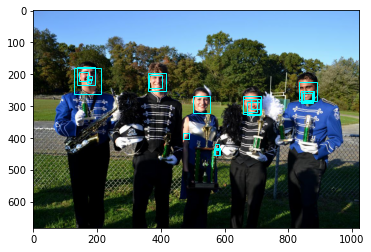

In [16]:
img = Image.open('../input/wider-data/WIDER/WIDER_train/0--Parade/0_Parade_marchingband_1_95.jpg')
bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
print(len(bounding_boxes))
show_boxes(img, bounding_boxes[:20])

#### Show more sample images from the training set

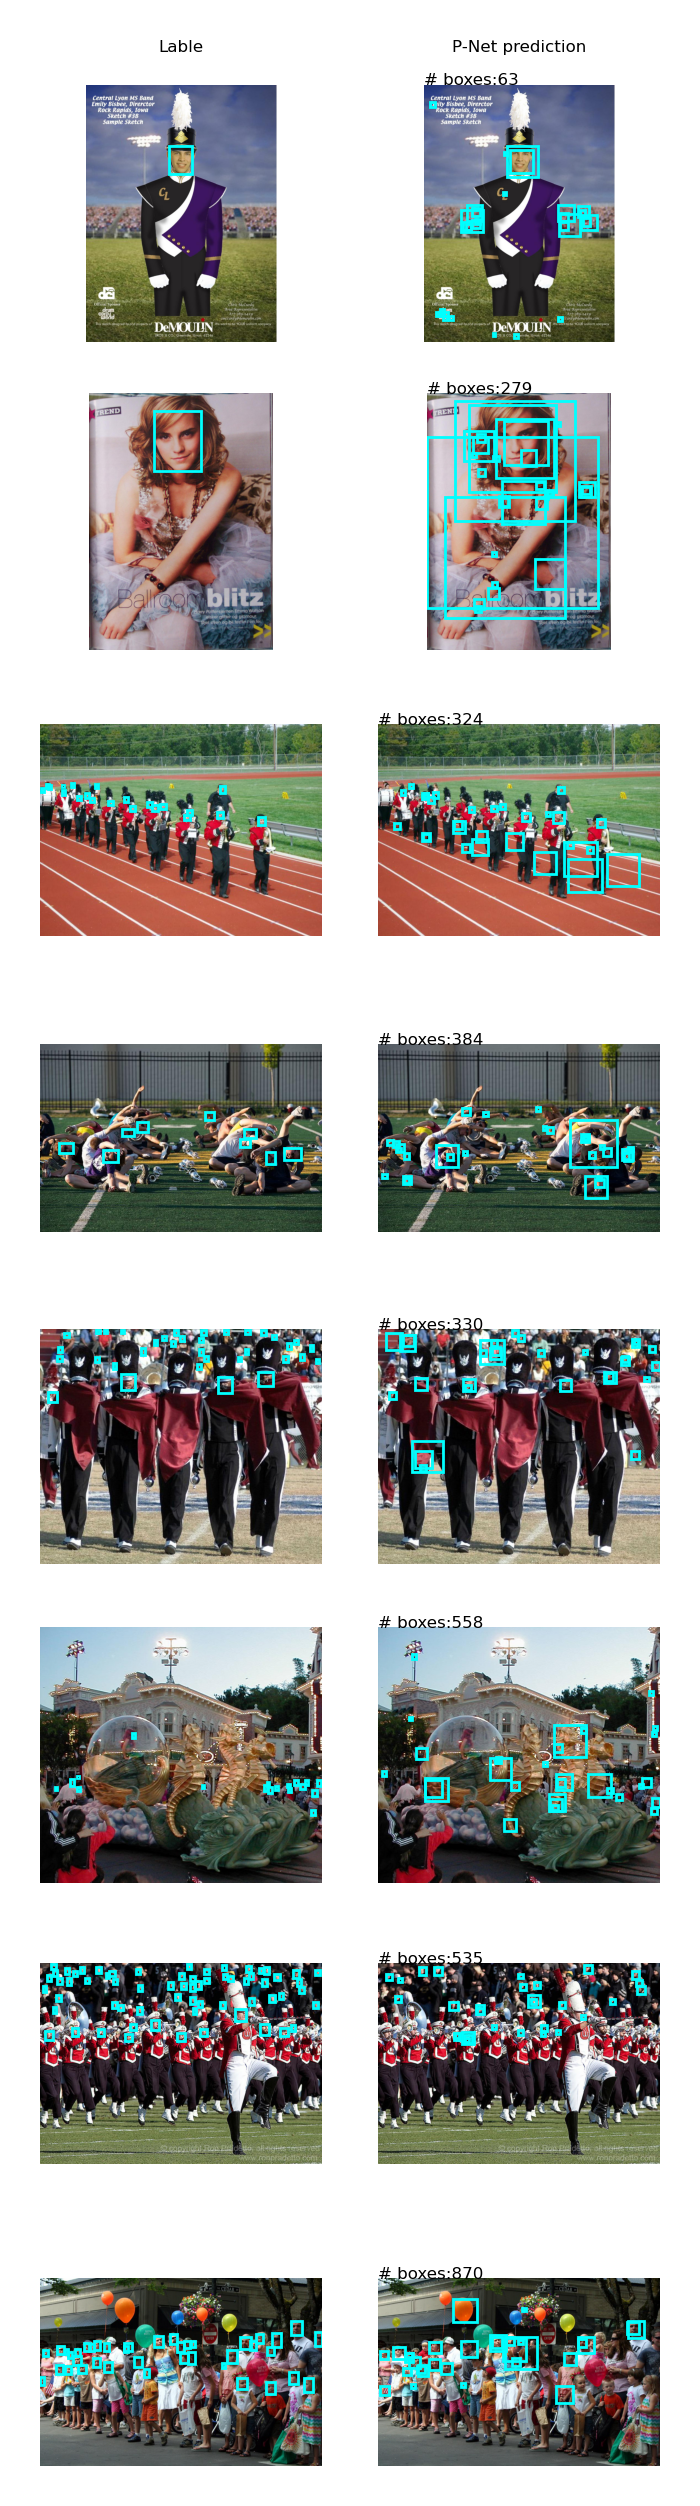

In [20]:
# get 8 fixed images
data_for_demo = create_pnet_data_txt_parser(train_txt_path,train_img_path ,num_data=8)


# demo and plot
fig, ax = plt.subplots(8,2,dpi = 400, figsize=(2,8))

for i in range(len(data_for_demo)):
    img_pth, gts = data_for_demo[i]
    img = Image.open(img_pth)
    bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    
    ax[i,0].imshow(img)
    for b in gts:
        ax[i,0].add_patch(plt.Rectangle((b[0], b[1]), b[2], b[3], fill=False, edgecolor = 'cyan',linewidth=0.5));
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# boxes:'+str(len(bounding_boxes)),fontsize=3)
    for b in bounding_boxes[:30]:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   

for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Lable",fontsize=3)
ax[0][1].set_title("P-Net prediction",fontsize=3)
fig.show()
fig.savefig('demo.png')

#### Show more sample images from the eval set

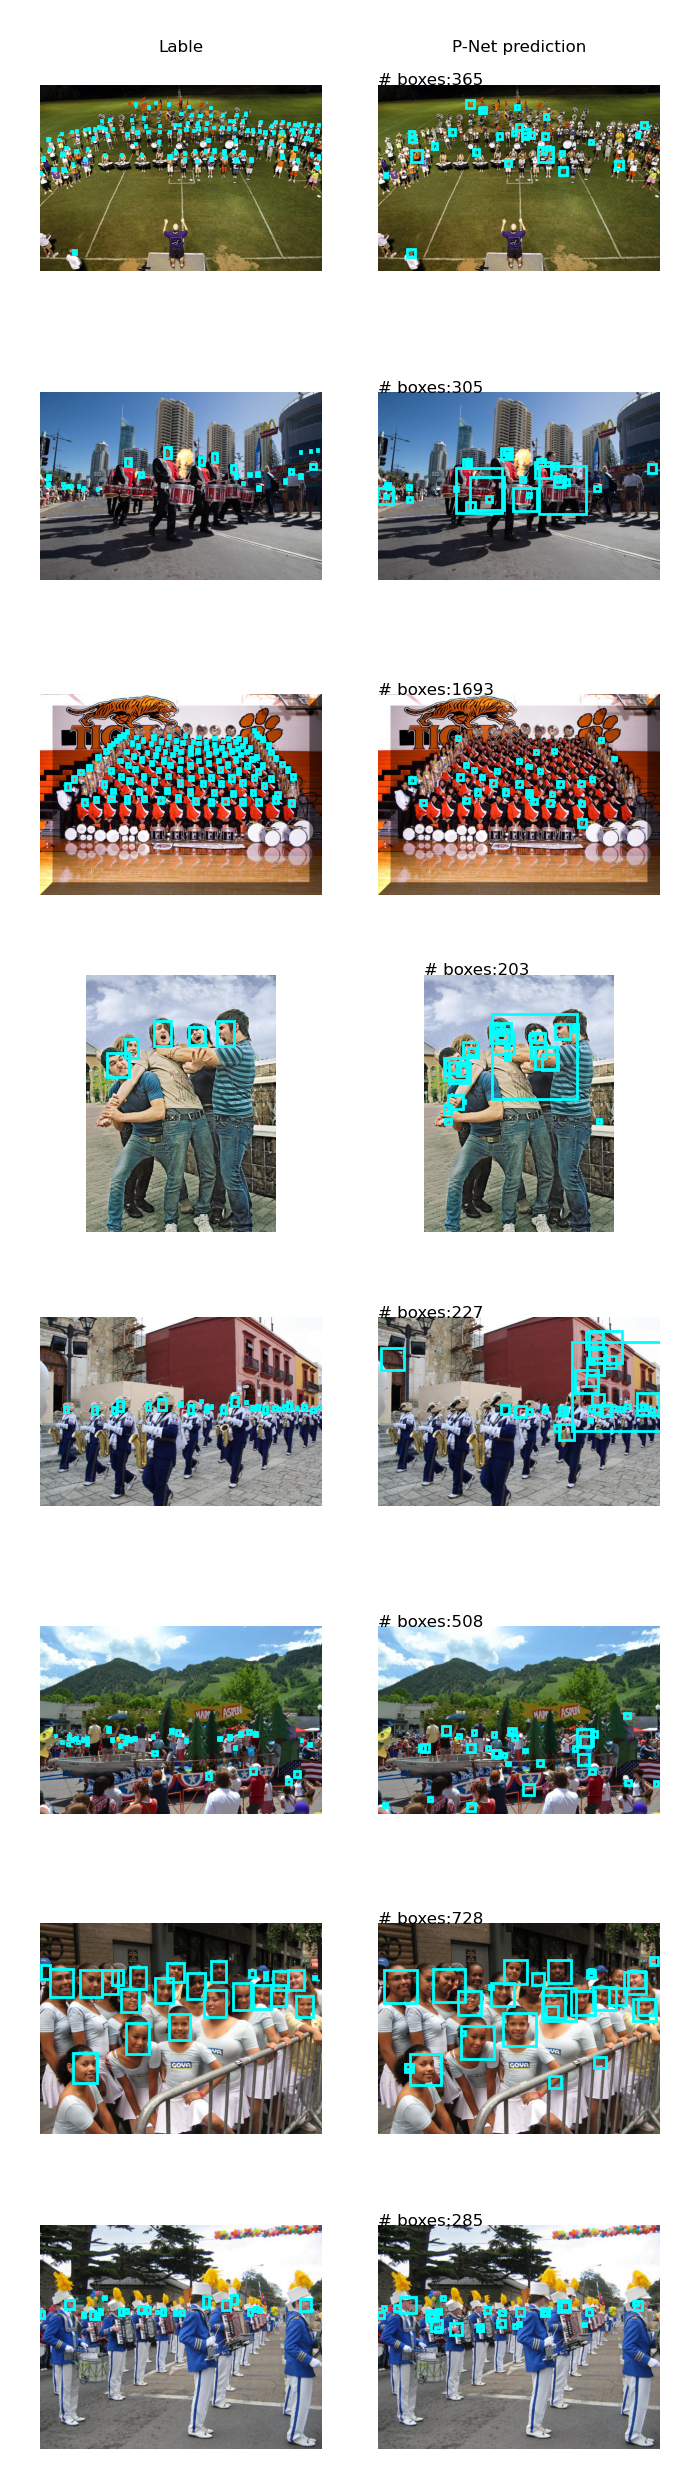

In [21]:
# get 8 fixed images
data_for_demo = create_pnet_data_txt_parser(eval_txt_path,eval_img_path ,num_data=8)


# demo and plot
fig, ax = plt.subplots(8,2,dpi = 400, figsize=(2,8))

for i in range(len(data_for_demo)):
    img_pth, gts = data_for_demo[i]
    img = Image.open(img_pth)
    bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    
    ax[i,0].imshow(img)
    for b in gts:
        ax[i,0].add_patch(plt.Rectangle((b[0], b[1]), b[2], b[3], fill=False, edgecolor = 'cyan',linewidth=0.5));
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# boxes:'+str(len(bounding_boxes)),fontsize=3)
    for b in bounding_boxes[:30]:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   

for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Lable",fontsize=3)
ax[0][1].set_title("P-Net prediction",fontsize=3)
fig.show()
fig.savefig('demo.png')

## Generate the Input Data for RNet  
- In this part, it puts the images into the PNet to get the prediction boxes and save the crop information and the name of the coresponding images in a txt file.

- The output txt file should have lines in this format:
      image_path * label, gt_x1, gt_y1, gt_x2, gt_y2, cr_x1, cr_y1, cr_x2, cr_y2 + ... + label, gt_x1, gt_y1, gt_x2, gt_y2, cr_x1, cr_y1, cr_x2, cr_y2 * \n
  Here is an example:
      ../input/wider-data/WIDER/WIDER_train/0--Parade/0_Parade_marchingband_1_462.jpg*n,668,226,681,246,888,348,967,427+n,668,226,681,246,437,455,504,522+p,668,226,681,246,434,435,556,557*\n

In [ ]:
train_img_faces = create_pnet_data_txt_parser(train_txt_path,train_img_path ,num_data=train_num)
eval_img_faces = create_pnet_data_txt_parser(eval_txt_path,eval_img_path ,num_data=eval_num)

In [ ]:
def get_size_faces(img_faces, index):
    def load_img(img_path):
        try:
            img = Image.open(img_path)
            img = img.convert('RGB')
        except Exception:
            print('*** warning loading fail!')
            return
        return img

    img_face = img_faces[index]
    img_path = img_face[0]
    faces = np.array(img_face[1])      
    faces[:, 2] += faces[:, 0]
    faces[:, 3] += faces[:, 1]
   
    img=load_img(img_path)
    return img, faces

def get_crop_img_label_box(img ,faces,pnet):
    iou_th = {'n': (0, 0.3), 'pf': (0.4, 0.65), 'p': (0.65, 1.0)}
    bounding_boxes = pnet_boxes(img, pnet)
    if bounding_boxes is None:
        return None, None, None
    
    crop_box = None
    closet_face = None
    label_boxes=[]
    width,height=img.size
    
    for id, box in enumerate(bounding_boxes, start=1):
        box = [min(max(0, int(box[i])), width if i % 2 == 0 else height) for i in range(4)]
        if box[2] - box[0] < 12: continue
        iou = IoU(box, faces)
        iou_max = iou.max()
        iou_index = iou.argmax()
        closet_face = faces[iou_index]             
                
        for temp_label in iou_th:
            if iou_max < iou_th[temp_label][0] or iou_max > iou_th[temp_label][1]:
                continue
            else:
                label = temp_label
                crop_box = box
                closet_face=[str(l) for l in closet_face]
                crop_box=[str(l) for l in crop_box]
                label_boxes.append([label,closet_face,crop_box])

    return label_boxes

In [ ]:
rnet_train_data=open('rnet_train_data.txt', 'w')
print('Train Begin')
for index in range(len(train_img_faces)):
    if index%500==0:
        print(index)
    img,faces=get_size_faces(train_img_faces, index)
    label_boxes=get_crop_img_label_box(img ,faces,pnet)
    img_path=train_img_faces[index][0]
    try:
        boxes='+'.join([w[0]+','+','.join(w[1])+','+','.join(w[2]) for w in label_boxes])
        rnet_train_data.write(img_path+'*'+boxes+'* \n')
    except:
        print('Wrong:',label_boxes)
rnet_train_data.close()   
print('Train End')

print('Eval Begin')
rnet_eval_data=open('rnet_eval_data.txt', 'w')
for index in range(len(eval_img_faces)):
    
    if index%500==0:
        print(index)
    img,faces=get_size_faces(eval_img_faces, index)
    label_boxes=get_crop_img_label_box(img ,faces,pnet)
    img_path=train_img_faces[index][0]
    try:
        boxes='+'.join([w[0]+','+','.join(w[1])+','+','.join(w[2]) for w in label_boxes])
        rnet_eval_data.write(img_path+'*'+boxes+'* \n')
    except:
        print('Wrong:',label_boxes)
rnet_eval_data.close()
